# 

In [1]:
# !pip install pandas matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import io
import re

In [162]:
# MAX_INT16 = 
# np.random.randint(-
MAX_INT16 = 2**15 - 1
MIN_INT16 = -MAX_INT16 - 1

def make_rand(n_rows, name, n):
    def make_one(i):
        n_actual_rows = int((1 + (np.random.random() - 0.5) / 10) * n_rows)
        df = pd.DataFrame(np.random.randint(MIN_INT16, MAX_INT16, size=(n_actual_rows, 6)), columns='ax ay az gx gy gz'.split())
        df['initial_row_angle'] = np.random.random() * 2 * np.pi
        df['name'] = name
        df['n'] = i
        return df
    return pd.concat((make_one(i) for i in range(n)))

# make_rand(80, 'random_sample', 1)

In [252]:
np.random.seed(42)

df = pd.concat([
        pd.read_csv(f)
        for f in [
            './data/ble-dump/52hz/4g-500dps/circle-rot-inv.csv',
            './data/ble-dump/52hz/4g-500dps/L-rot-inv.csv',
            './data/ble-dump/52hz/4g-500dps/X-rot-inv.csv',
            './data/ble-dump/52hz/4g-500dps/down_I-rot-inv.csv',
            './data/ble-dump/52hz/4g-500dps/uptick-rot-inv.csv',
        ]
    ] + [
        # make_rand(15, 'short_rand', 5),
        # make_rand(52 * 3, 'long_rand', 6),
    ])
# Shortcut.
df['r'] = df['initial_row_angle']
df

,ax,ay,az,gx,gy,gz,name,n,initial_row_angle,r
0,8218,599,9025,-2366,-150,-576,circle,0,0.214708,0.214708
1,9079,105,14757,-2795,509,-2108,circle,0,0.214708,0.214708
2,8416,-833,18242,-1938,450,-4052,circle,0,0.214708,0.214708
3,6703,-2384,20087,-342,-135,-6042,circle,0,0.214708,0.214708
4,2226,-3342,20005,1532,-149,-8045,circle,0,0.214708,0.214708
...,...,...,...,...,...,...,...,...,...,...
351,-3943,-2981,32692,-8068,2072,-237,uptick,11,0.051473,0.051473
352,-3245,-2164,20525,-1074,46,136,uptick,11,0.051473,0.051473
353,2119,-1448,7748,788,-1828,856,uptick,11,0.051473,0.051473
354,3294,-968,8780,-707,-1493,431,uptick,11,0.051473,0.051473


In [253]:
def plot_mov(df, name, n, ax):
    df[
        (df.name == name) & (df.n == n)
    ][['ax', 'ay', 'az', 'gx', 'gy', 'gz']].plot(ax=ax)
    ax.set_title(f'{name} #{n}')
    ax.legend(bbox_to_anchor=(1.0, 1.0))

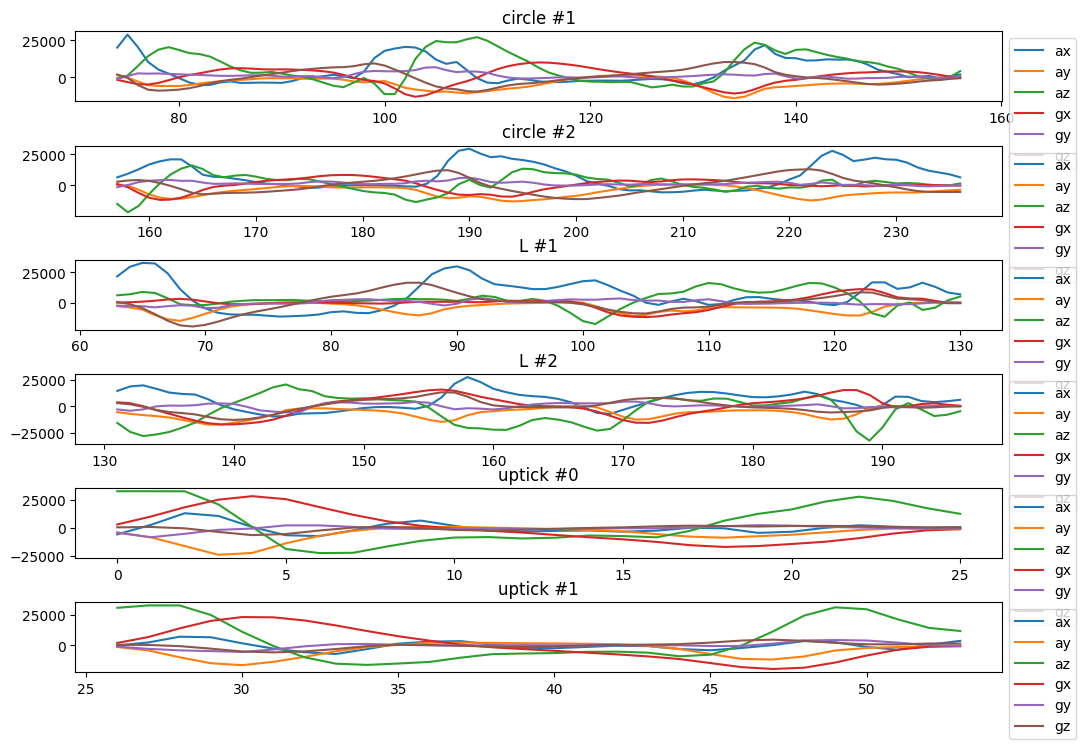

In [256]:
N_EACH = 2

fig, axs = plt.subplots(3 * N_EACH, 1, figsize=(10, 7))
fig.tight_layout()

for i in range(N_EACH):
    plot_mov(df, 'circle', i+1, axs[i])

for i in range(N_EACH):
    plot_mov(df, 'L', i+1, axs[i + N_EACH])
    
for i in range(N_EACH):
    plot_mov(df, 'uptick', i, axs[i + 2*N_EACH])



In [257]:
#!pip install dtw-python
# !pip install seaborn dtw-python

In [258]:
import dtw

# https://dynamictimewarping.github.io/python/

Text(0, 0.5, 'circle #4')

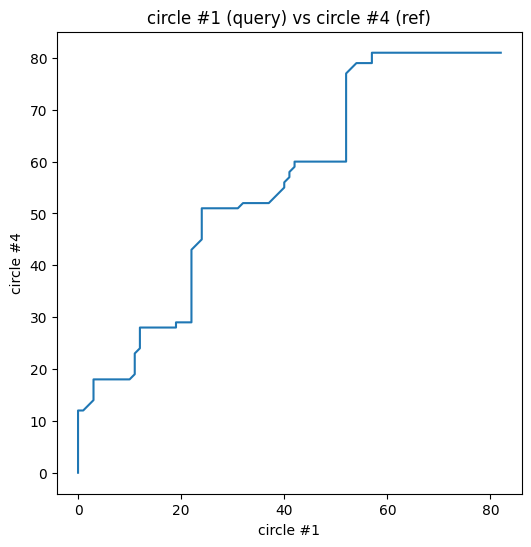

In [259]:
DATA_COLS = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
# DATA_COLS = ['ax', 'ay', 'az']

def mov_df(df, name, n):
    return df[(df.name == name) & (df.n == n)][DATA_COLS]

res = dtw.dtw(
    # Query.
    mov_df(df, 'circle', 1),
    # Reference.
    mov_df(df, 'circle', 4)
)
ax = res.plot()
ax.set_title('circle #1 (query) vs circle #4 (ref)')
ax.set_xlabel('circle #1')
ax.set_ylabel('circle #4')

Text(0, 0.5, 'circle #4')

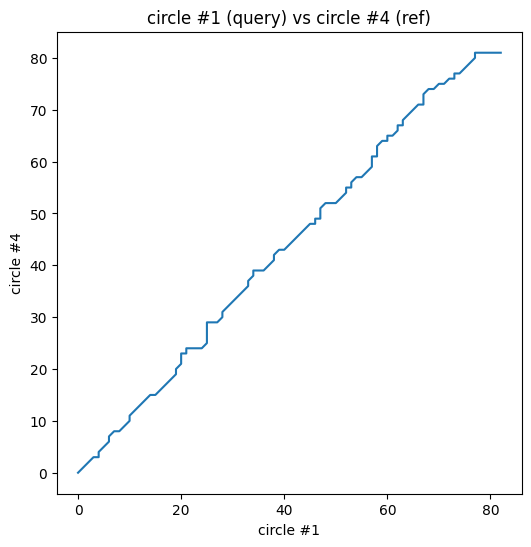

In [260]:
import math
proj_df = df.copy(deep=True)
proj_df['az'] = df['az'] * np.cos(df['r']) - df['ax'] * np.sin(df['r'])
proj_df['ax'] = df['az'] * np.sin(df['r']) + df['ax'] * np.cos(df['r'])
proj_df['gz'] = df['gz'] * np.cos(df['r']) - df['gx'] * np.sin(df['r'])
proj_df['gx'] = df['gz'] * np.sin(df['r']) + df['gx'] * np.cos(df['r'])
# proj_df['ax'] = np.sin(df['az']) + np.cos(df['ax'])
# proj_df['gz'] = np.cos(df['gz']) + np.sin(df['gx'])
# proj_df['gx'] = np.sin(df['gz']) + np.cos(df['gx'])

res = dtw.dtw(
    # Query.
    mov_df(proj_df, 'circle', 1),
    # Reference.
    mov_df(proj_df, 'circle', 4)
)
ax = res.plot()
ax.set_title('circle #1 (query) vs circle #4 (ref)')
ax.set_xlabel('circle #1')
ax.set_ylabel('circle #4')

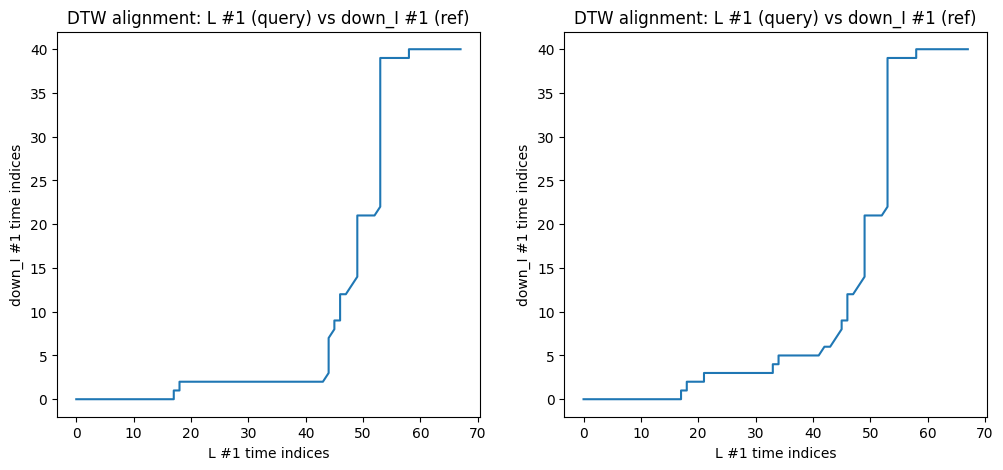

In [261]:
DATA_COLS = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

def mov_df(df, name, n):
    return df[(df.name == name) & (df.n == n)][DATA_COLS]

def plot(ax, name1, i1, name2, i2, window_size=10e3):
    res = dtw.dtw(
        # Query.
        mov_df(df, name1, i1),
        # Reference.
        mov_df(df, name2, i2),
        # window_type="sakoechiba",
        # window_type="itakura",
        window_type="slantedband",
        window_args={'window_size': window_size},
    )
    ax.plot(res.index1, res.index2)
    ax.set_title(f'DTW alignment: {name1} #{i1} (query) vs {name2} #{i2} (ref)')
    ax.set_xlabel(f'{name1} #{i1} time indices')
    ax.set_ylabel(f'{name2} #{i2} time indices')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# plot(ax1, 'circle', 1, 'circle', 4)
plot(ax1, 'L', 1, 'down_I', 1)
plot(ax2, 'L', 1, 'down_I', 1, window_size=20)

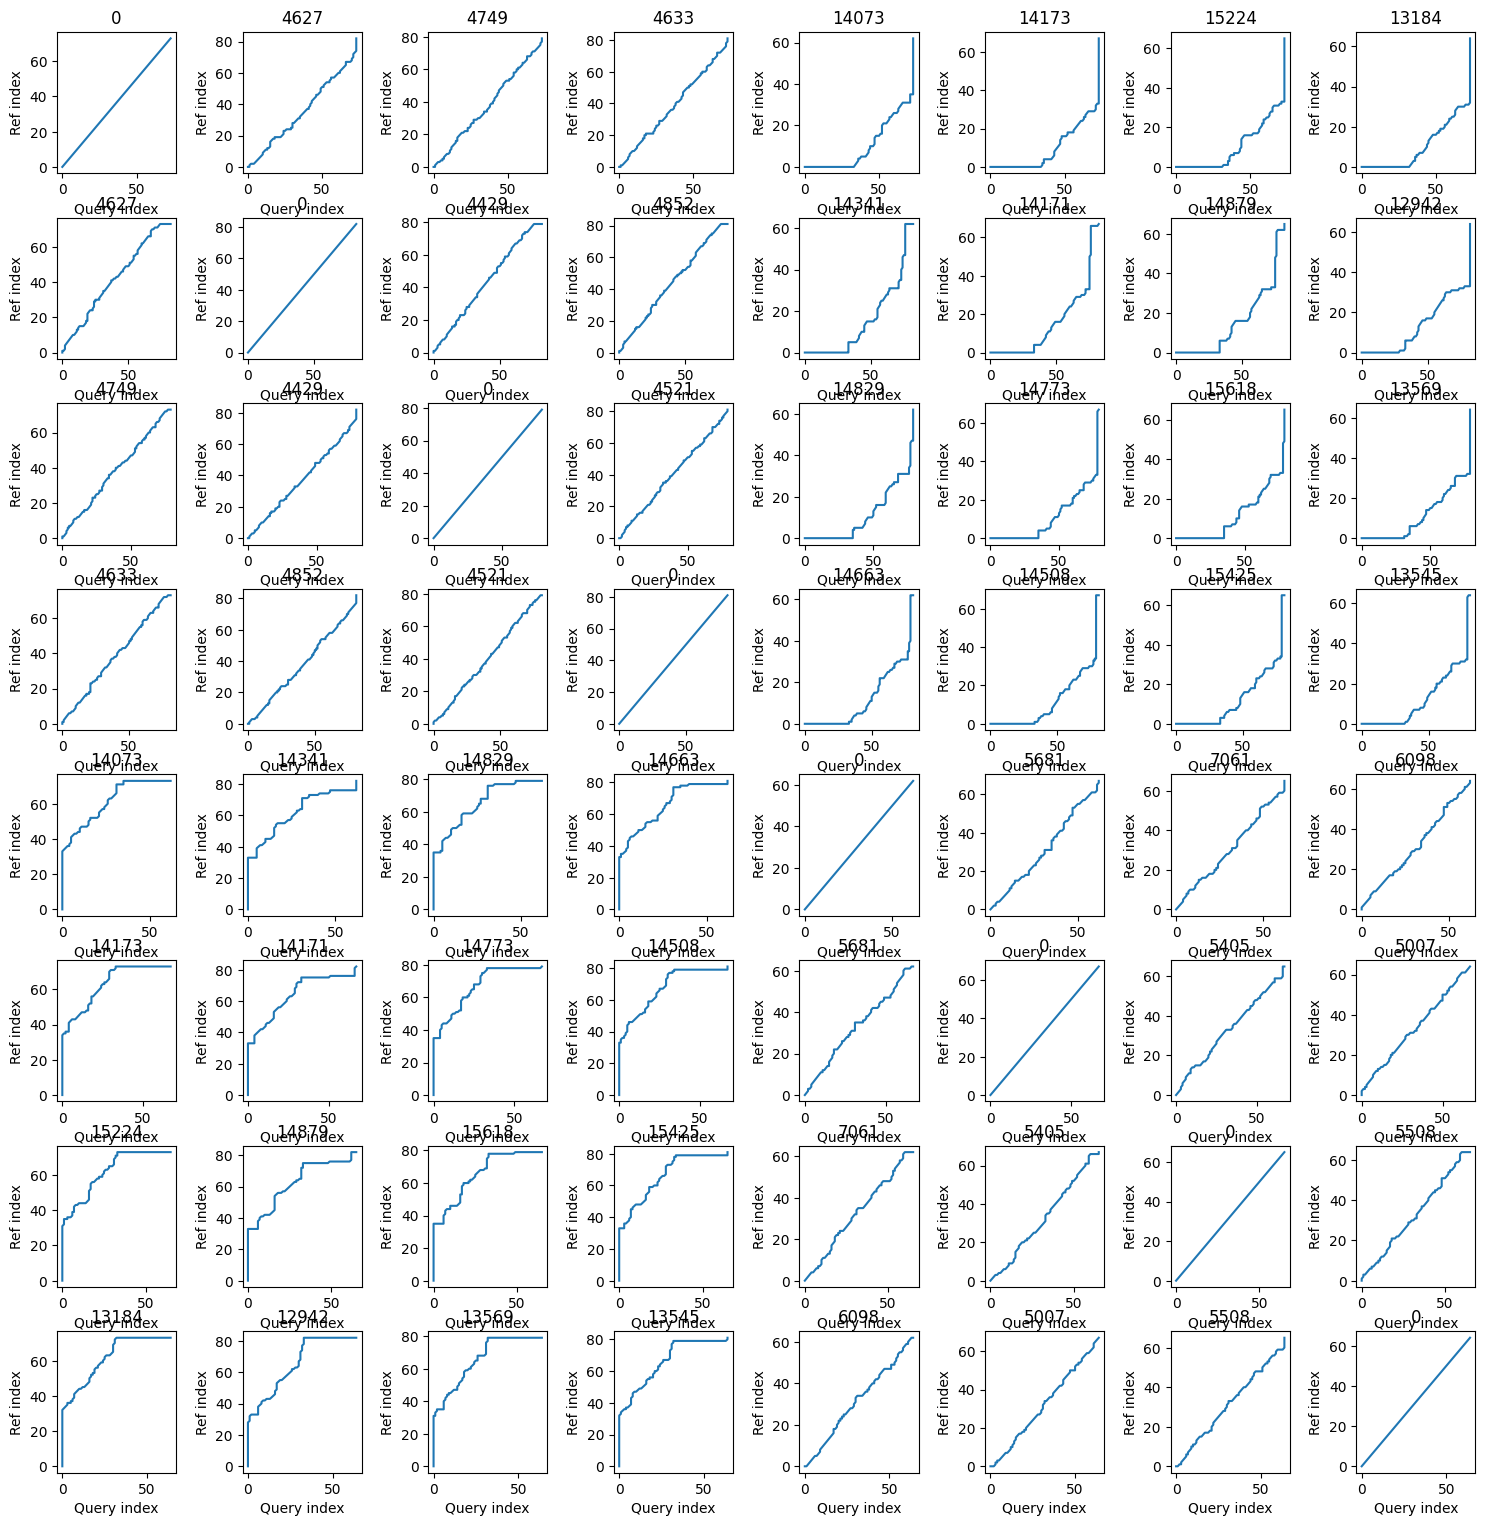

In [262]:
dfs = [mov_df(proj_df, 'circle', i) for i in range(4)] + \
      [mov_df(proj_df, 'L', i) for i in range(4)]



fig, axs = plt.subplots(len(dfs), len(dfs), figsize=(15, 15))
fig.tight_layout()
for i, df1 in enumerate(dfs):
    for j, df2 in enumerate(dfs):
        ax = axs[i][j]
        align = dtw.dtw(df1, df2) 
        # align = dtw.dtw(df1, df2, window_type="slantedband", window_args={'window_size': 20})
        # try:
        #     align = dtw.dtw(df1, df2, window_type="sakoechiba", window_args={'window_size': 20})
        # except ValueError:
        #     continue
        # https://github.com/DynamicTimeWarping/dtw-python/blob/56d2e09dd4409f2d7bafb465889d696a25ebdd2c/dtw/dtwPlot.py#L79
        ax.plot(align.index1, align.index2)
        ax.set_xlabel("Query index")
        ax.set_ylabel("Ref index")
        ax.set_title(f'{int(align.normalizedDistance)}')

In [263]:
import itertools

keys = [k for k, v in df.groupby(['name', 'n'])]

def k_dist(k1, k2):
    return dtw.dtw(mov_df(proj_df, *k1), mov_df(proj_df, *k2)).normalizedDistance
    # return dtw.dtw(mov_df(df, *k1), mov_df(df, *k2), window_type="slantedband", window_args={'window_size': 440}).normalizedDistance
    # return dtw.dtw(mov_df(df, *k1), mov_df(df, *k2), window_type="itakura").normalizedDistance

def length_diff(k1, k2):
    return mov_df(proj_df, *k1).shape[0] - mov_df(proj_df, *k2).shape[0]

def name(k):
    s, n = k
    return f'{s}_{n}'

records = [{
    'k1': name(k1),
    'k2': name(k2),
    'same_gesture': k1[0] == k2[0],
    'dist': k_dist(k1, k2),
    'length_diff': length_diff(k1, k2),
    }
    for a, b in itertools.combinations_with_replacement(keys, 2)
    for k1, k2 in [(a, b), (b, a)]
    if k1 != k2
]

dist_matrix = pd.DataFrame.from_records(records)

In [264]:
dist_df = dist_matrix.pivot(index='k1', columns='k2', values='dist').fillna(0.0)

<Axes: xlabel='k2', ylabel='k1'>

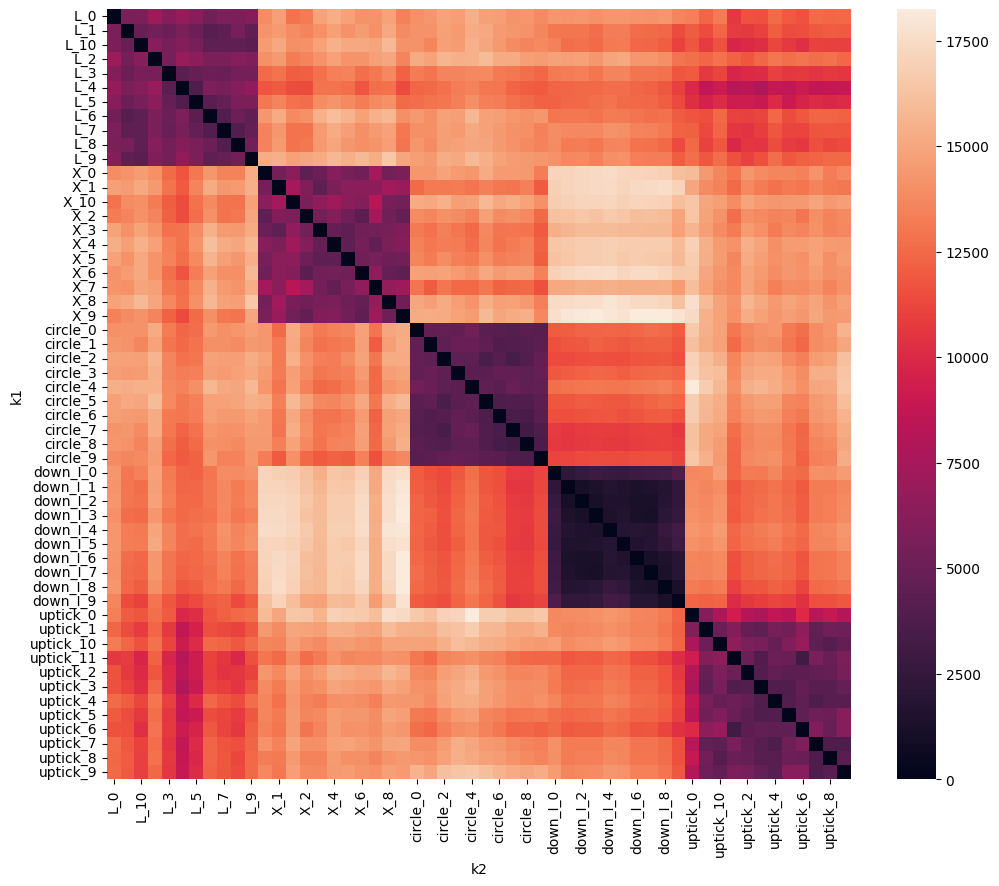

In [265]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(12,10))
sns.heatmap(dist_df, ax=ax)

In [266]:
# Which row is the min dist to circle_0?
dist_df.columns[dist_df['circle_0'].argmin()]

'circle_0'

Text(0, 0.5, 'Number of pairs')

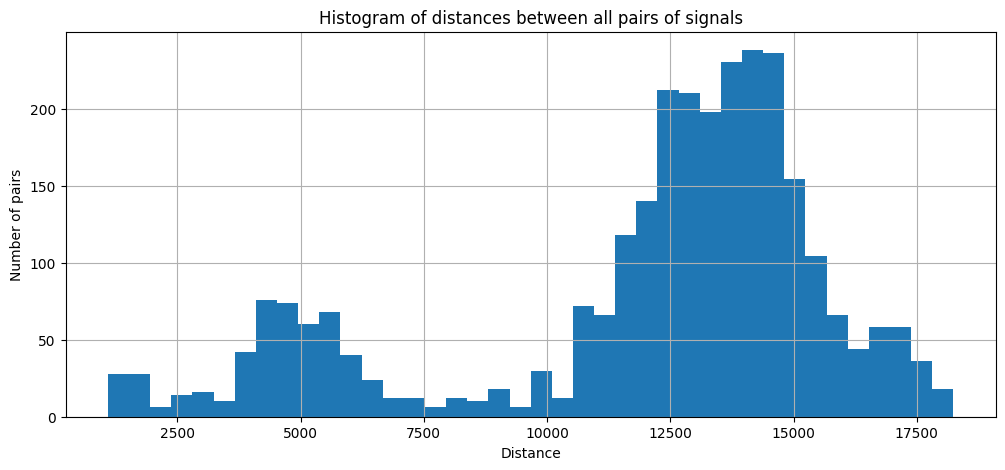

In [267]:
# dist_matrix.groupby('same_gesture').hist('dist')
fig, ax = plt.subplots(1, 1, figsize=(12,5))
dist_matrix.hist('dist', ax=ax, bins=40)
ax.set_title("Histogram of distances between all pairs of signals")
ax.set_xlabel("Distance")
ax.set_ylabel("Number of pairs")

# Length Difference

<Axes: xlabel='k2', ylabel='k1'>

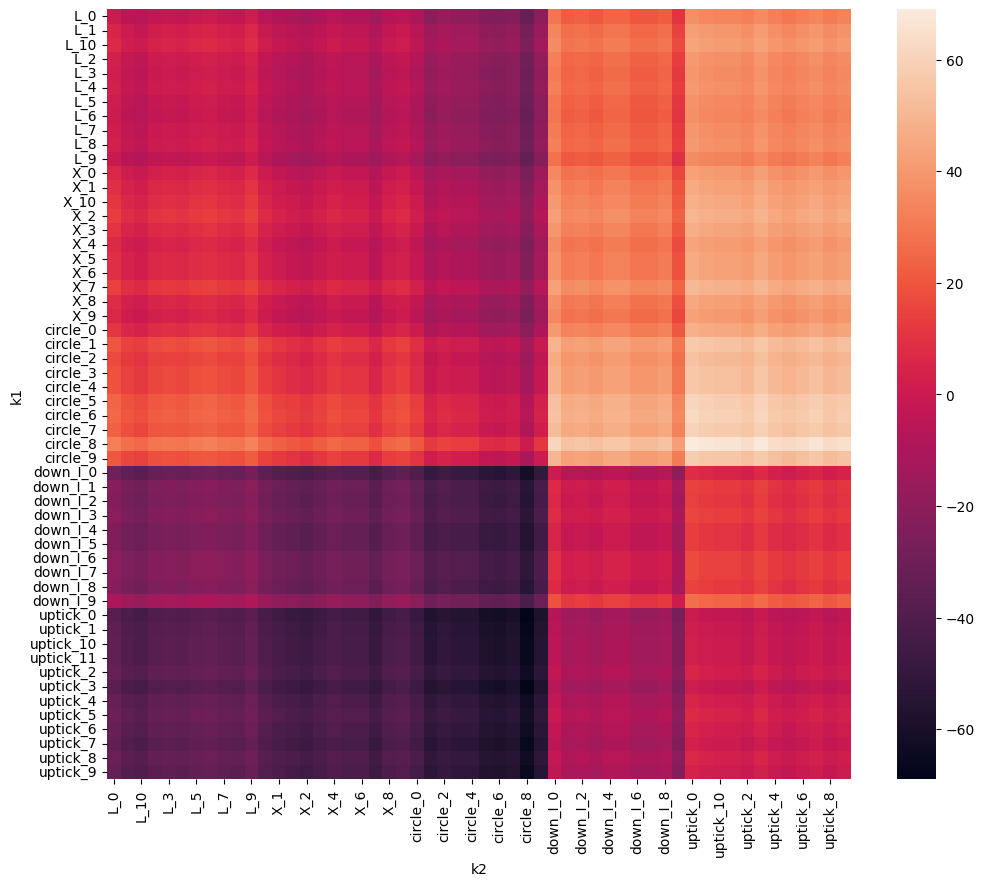

In [268]:
length_diff_df = dist_matrix.pivot(index='k1', columns='k2', values='length_diff').fillna(0.0)
fig, ax = plt.subplots(1, 1, figsize=(12,10))
sns.heatmap(length_diff_df, ax=ax)

Text(0, 0.5, 'Number of pairs')

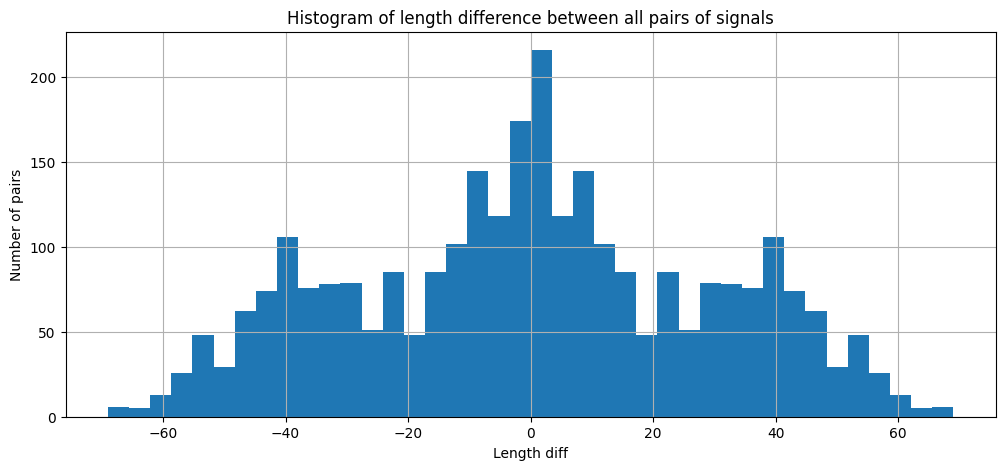

In [269]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
dist_matrix.hist('length_diff', ax=ax, bins=40)
ax.set_title("Histogram of length difference between all pairs of signals")
ax.set_xlabel("Length diff")
ax.set_ylabel("Number of pairs")

same_gesture
False    [[Axes(0.125,0.11;0.775x0.77)]]
True     [[Axes(0.125,0.11;0.775x0.77)]]
dtype: object

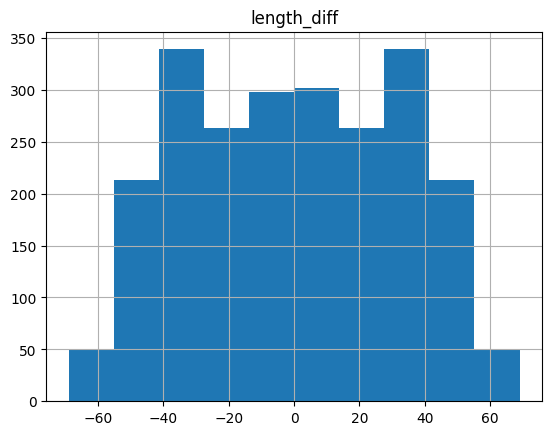

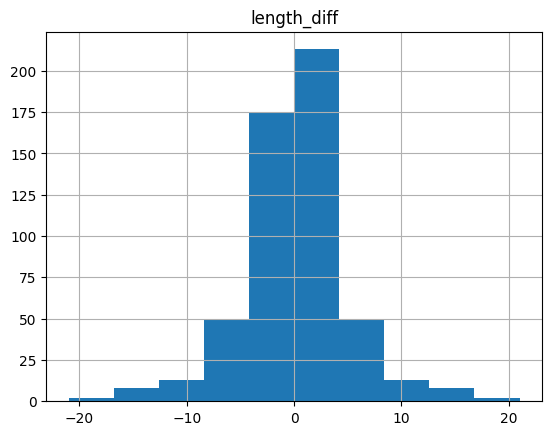

In [270]:
dist_matrix.groupby('same_gesture').hist('length_diff')